Starting code for a MLP classifier for cardiac arrest for tabular data - Josh

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# cardiac_df = pd.read_csv("cardiac_arrests.csv")
# cardiac_df['cardiac_arrest'] = 1
# non_cardiac_df = pd.read_csv("non_cardiac_grouped.csv")
# non_cardiac_df.head()
df = pd.read_csv("1000_nonca_574_ca.csv")

In [3]:
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,ADMITTIME,DISCHTIME,DOB,age
0,3727,92373,117627,101.0,19.0,99.0,NaN,NaN,F,0,2192/10/17 13:14,2192/12/7 16:15,2150/10/24 0:00,42
1,8940,79240,142189,96.0,23.0,96.0,NaN,NaN,M,0,2148/8/30 10:30,2148/9/4 15:00,2085/4/30 0:00,63
2,18943,29137,188600,89.0,20.0,99.0,NaN,NaN,M,0,2108/1/24 16:21,2108/1/27 15:00,2039/3/9 0:00,68
3,13131,73925,161982,71.5,17.0,99.0,NaN,NaN,M,0,2176/8/20 12:23,2176/8/21 16:00,2098/2/12 0:00,78
4,13657,88976,164360,78.0,14.0,98.0,NaN,NaN,M,0,2154/7/26 2:51,2154/7/30 15:00,2086/9/17 0:00,67


In [4]:
df.drop(['ADMITTIME', 'DISCHTIME', 'DOB'], axis=1, inplace=True)
df.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,cardiac,age
0,3727,92373,117627,101.0,19.0,99.0,NaN,NaN,F,0,42
1,8940,79240,142189,96.0,23.0,96.0,NaN,NaN,M,0,63
2,18943,29137,188600,89.0,20.0,99.0,NaN,NaN,M,0,68
3,13131,73925,161982,71.5,17.0,99.0,NaN,NaN,M,0,78
4,13657,88976,164360,78.0,14.0,98.0,NaN,NaN,M,0,67


In [5]:
df = df[['SUBJECT_ID', 'HADM_ID', '220045', '220210', '220277', '224167', '227243', 'gender','age','cardiac']]
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,92373,117627,101.0,19.0,99.0,NaN,NaN,F,42,0
1,79240,142189,96.0,23.0,96.0,NaN,NaN,M,63,0
2,29137,188600,89.0,20.0,99.0,NaN,NaN,M,68,0
3,73925,161982,71.5,17.0,99.0,NaN,NaN,M,78,0
4,88976,164360,78.0,14.0,98.0,NaN,NaN,M,67,0


In [6]:
# pd.get_dummies(df['gender'])
cleanup_nums = {"gender":     {"F": 0, "M": 1}}
df.replace(cleanup_nums, inplace=True)
df.head()

,SUBJECT_ID,HADM_ID,220045,220210,220277,224167,227243,gender,age,cardiac
0,92373,117627,101.0,19.0,99.0,NaN,NaN,0,42,0
1,79240,142189,96.0,23.0,96.0,NaN,NaN,1,63,0
2,29137,188600,89.0,20.0,99.0,NaN,NaN,1,68,0
3,73925,161982,71.5,17.0,99.0,NaN,NaN,1,78,0
4,88976,164360,78.0,14.0,98.0,NaN,NaN,1,67,0


In [7]:
df.drop(['SUBJECT_ID','HADM_ID','224167','227243'], axis=1, inplace=True)
df.head(2)

,220045,220210,220277,gender,age,cardiac
0,101.0,19.0,99.0,0,42,0
1,96.0,23.0,96.0,1,63,0


Look for a potential class imbalance here

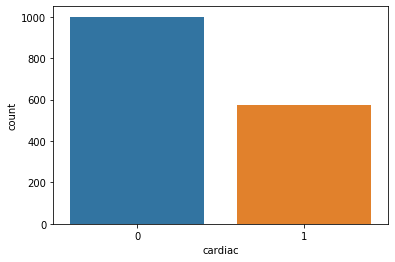

In [8]:
sns.countplot(x = 'cardiac', data=df)

Encode Output Class (remaps the labels to start from 0) (not sure if needed)

In [9]:
# df['Cardiac_arrest'] = df['Cardiac_arrest'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Cardiac_arrest'].replace(encode_map, inplace=True)

Create Input and Output Data

In [10]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [31]:
X.head(2)

,220045,220210,220277,gender,age
0,101.0,19.0,99.0,0,42
1,96.0,23.0,96.0,1,63


In [33]:
X=X.fillna(X.mean())
y=y.fillna(y.mean())

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [35]:
X_train.head(5)

,220045,220210,220277,gender,age
707,71.0,22.0,97.0,1,51
229,76.0,13.0,97.0,0,68
1191,89.5,22.0,100.0,0,73
80,70.0,17.0,96.0,1,89
999,101.0,15.0,96.0,0,73


In [36]:
y_train.head(5)

707     0
229     0
1191    1
80      0
999     0
Name: cardiac, dtype: int64

Standardize Input Values

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Model HyperParameters

In [38]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

Define a Dataloader

In [39]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

Initialize a dataloader with a batch_size = 1 for our test dataloader.

In [40]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

The input to our first nn.Linear layer would be 16 Since the number of input features in our dataset is 16

In [41]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 5.
        self.layer_1 = nn.Linear(5, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

Check for GPU

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Initialize optimizer and loss function

In [43]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=5, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [44]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

Train the model

In [45]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.70739 | Acc: 54.235
Epoch 002: | Loss: 0.64674 | Acc: 62.588
Epoch 003: | Loss: 0.63308 | Acc: 63.529
Epoch 004: | Loss: 0.61120 | Acc: 66.941
Epoch 005: | Loss: 0.59607 | Acc: 67.882
Epoch 006: | Loss: 0.58952 | Acc: 67.647
Epoch 007: | Loss: 0.57713 | Acc: 70.529
Epoch 008: | Loss: 0.58046 | Acc: 68.765
Epoch 009: | Loss: 0.57022 | Acc: 69.647
Epoch 010: | Loss: 0.56243 | Acc: 70.941
Epoch 011: | Loss: 0.55562 | Acc: 72.176
Epoch 012: | Loss: 0.56736 | Acc: 70.765
Epoch 013: | Loss: 0.55284 | Acc: 72.118
Epoch 014: | Loss: 0.54393 | Acc: 71.647
Epoch 015: | Loss: 0.55676 | Acc: 71.882
Epoch 016: | Loss: 0.55221 | Acc: 71.176
Epoch 017: | Loss: 0.53536 | Acc: 72.824
Epoch 018: | Loss: 0.55504 | Acc: 70.941
Epoch 019: | Loss: 0.54763 | Acc: 71.647
Epoch 020: | Loss: 0.53323 | Acc: 72.235
Epoch 021: | Loss: 0.53961 | Acc: 72.588
Epoch 022: | Loss: 0.54136 | Acc: 72.647
Epoch 023: | Loss: 0.54724 | Acc: 72.118
Epoch 024: | Loss: 0.53683 | Acc: 72.176
Epoch 025: | Los

Test the model

In [46]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [47]:
# Calculate the confusion matrix
confusion_matrix(y_test, y_pred_list)

array([[261,  60],
       [137,  62]])

In [48]:
# Print classification report with precision, recall, and F1 score
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       321
           1       0.51      0.31      0.39       199

    accuracy                           0.62       520
   macro avg       0.58      0.56      0.56       520
weighted avg       0.60      0.62      0.60       520

